In [1]:
source(file = "R/packages.R")
source(file = "R/utils.R")
source(file = "R/variables.R")
source(file = "R/mysql.R")

library(RMySQL)
library(ggplot2)
library(reshape)
library(sqldf)
library(digest)
library(xtable)

Warning message:
"package 'RMySQL' was built under R version 3.3.3"Loading required package: DBI
Loading required package: gsubfn
Loading required package: proto
Could not load tcltk.  Will use slower R code instead.
Loading required package: RSQLite

Attaching package: 'RSQLite'

The following object is masked from 'package:RMySQL':

    isIdCurrent

sqldf will default to using MySQL


# DataSet Statistics

In [2]:
print("Running database queries...")
con <- dbConnect(dbDriver("MySQL"), user = mysql.user, password = mysql.passwd, 
                 dbname = mysql.db, host = mysql.host)

[1] "Running database queries..."


In [6]:
# Total repos
res <- dbSendQuery(con, "select count(*) as cnt from projects")
repos <- fetch(res, n = -1)
print(sprintf("Total repos: %d",repos$cnt))

[1] "Total repos: 64263412"


In [7]:
# Total users
res <- dbSendQuery(con, "select count(*) as cnt from users")
users <- fetch(res, n = -1)
print(sprintf("Total users: %d",users$cnt))

[1] "Total users: 19925203"


In [1]:
64263412/19925203

[1] 3.225232

In [8]:
# Original repos
res <- dbSendQuery(con, "select count(*) as cnt from projects where forked_from is null and deleted is false and name not regexp '^.*\\.github\\.com$' and name <> 'try_git' and name <> 'dotfiles' and name <> 'vimfiles'")
orig_repos <- fetch(res, n = -1)
print(sprintf("Original repos: %f",orig_repos$cnt))

[1] "Original repos: 36419081.000000"


In [9]:
# % of original repos 
print(sprintf("Original repos: %f",(orig_repos$cnt/repos$cnt) * 100))


[1] "Original repos: 56.671565"


In [5]:
# Total pull requests
res <- dbSendQuery(con, "select count(*) as cnt from pull_requests")
pullreqs <- fetch(res, n = -1)
print(sprintf("Total pull requests: %d",pullreqs$cnt))


[1] "Total pull requests: 26505602"


In [3]:
# % of pull req comments by non-repo members 
res <- dbSendQuery(con, "select count(pr.id) as cnt from pull_requests pr, pull_request_comments prc where pr.id = prc.pull_request_id;")
prc_non_members <- fetch(res, n = -1)
print(sprintf("Pull request comments by non project members: %f", prc_non_members$cnt))
# 

[1] "Pull request comments by non project members: 17161533.000000"


In [6]:
# % of pull req comments by non-repo members 
res <- dbSendQuery(con, "select count(*) as cnt from project_commits pc, commits c;")
test <- fetch(res, n = -1)
print(sprintf("Pull request comments by non project members: %f", test$cnt))
# 

[1] "Pull request comments by non project members: 3922799518447018496.000000"


[1] "Pullreqs per project (mean): 7.851780"
[1] "Pullreqs per project (median): 1.000000"
[1] "Pullreqs per project (95 perc): 23"
[1] "Pullreqs per project (5 perc): 1"


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


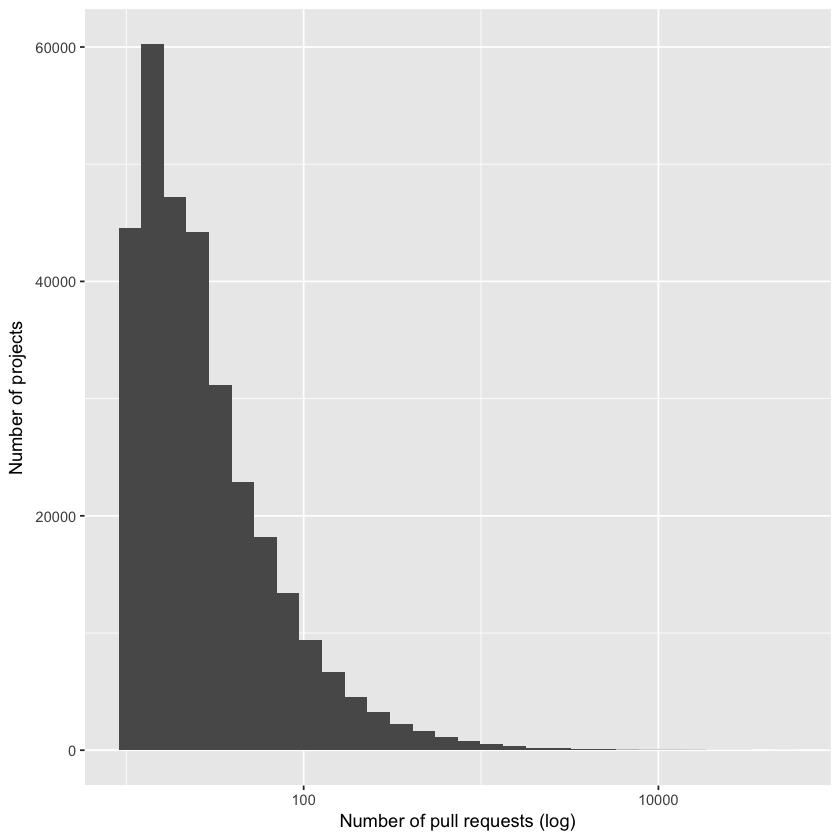

In [7]:
# Distribution of pull requests per project
res <- dbSendQuery(con, "select pr.base_repo_id as repoid, count(*) as cnt from projects p, pull_requests pr  where p.forked_from is null and p.name not regexp '^.*\\.github\\.com$' and p.name <> 'try_git' and p.name <> 'dotfiles' and p.name <> 'vimfiles'  and pr.base_repo_id = p.id and exists (select prh.created_at from pull_request_history prh where prh.pull_request_id = pr.id and prh.action='opened' and year(prh.created_at) > 2010)  group by pr.base_repo_id order by count(*) desc")
pullreqs <- fetch(res, n = -1)
print(sprintf("Pullreqs per project (mean): %f", mean(pullreqs$cnt)))
print(sprintf("Pullreqs per project (median): %f", median(pullreqs$cnt)))
print(sprintf("Pullreqs per project (95 perc): %d", quantile(pullreqs$cnt, 0.95)))
print(sprintf("Pullreqs per project (5 perc): %d", quantile(pullreqs$cnt, 0.05)))
qplot(cnt, data = subset(pullreqs, cnt > 10), geom = "histogram", log = "x", ylab = "Number of projects", xlab = "Number of pull requests (log)")


In [5]:
# Overall pull req stats - opened
res <- dbSendQuery(con, "select count(*) as cnt from projects p, pull_requests pr  where p.forked_from is null and p.name not regexp '^.*\\.github\\.com$' and p.name <> 'try_git' and p.name <> 'dotfiles' and p.name <> 'vimfiles'and pr.base_repo_id = p.id and exists (select prh.created_at from pull_request_history prh where prh.pull_request_id = pr.id and prh.action='opened' and year(prh.created_at) > 2010)")
opened_pullreqs <- fetch(res, n = -1)$cnt

In [9]:
# Overall pull req stats - closed
res <- dbSendQuery(con, "select count(*) as cnt from projects p, pull_requests pr  where p.forked_from is null and p.name not regexp '^.*\\.github\\.com$' and p.name <> 'try_git' and p.name <> 'dotfiles' and p.name <> 'vimfiles' and pr.base_repo_id = p.id and exists (select prh.created_at from pull_request_history prh where prh.pull_request_id = pr.id and prh.action='closed' and year(prh.created_at) > 2010)")
closed_pullreqs <- fetch(res, n = -1)$cnt

In [ ]:
# Overall pull req stats - merged
res <- dbSendQuery(con, "select count(*) as cnt from projects p, pull_requests pr  where p.forked_from is null and p.name not regexp '^.*\\.github\\.com$' and p.name <> 'try_git' and p.name <> 'dotfiles' and p.name <> 'vimfiles' and pr.base_repo_id = p.id and pr.merged = true and exists (select prh.created_at from pull_request_history prh where prh.pull_request_id = pr.id  and year(prh.created_at) > 2010)")
merged_pullreqs <- fetch(res, n = -1)$cnt
print(sprintf("Perc merged pull requests: %f", (merged_pullreqs/opened_pullreqs) * 100))


In [ ]:
# Pull reqs per month plot
res <- dbSendQuery(con, "select last_day(prh.created_at) as cdate, count(*) as pull_reqs from pull_requests pr, pull_request_history prh where prh.pull_request_id = pr.id and prh.action = 'opened' and unix_timestamp(prh.created_at) between 1328054400 and 1375228800 group by  month(prh.created_at), year(prh.created_at) order by prh.created_at")
pullreqs_per_month <- fetch(res, n = -1)

In [ ]:
res <- dbSendQuery(con, "select cdate, count(repo) as repos_with_pull_reqs from (select last_day(prh.created_at) as cdate, pr.base_repo_id as repo from pull_requests pr, pull_request_history prh where pr.id = prh.pull_request_id and prh.action = 'opened' and unix_timestamp(prh.created_at) between 1328054400 and 1375228800 group by pr.base_repo_id, month(prh.created_at), year(prh.created_at)  order by cdate) as a group by cdate")
repos_with_pullreqs_per_month <- fetch(res, n = -1)

In [ ]:
# Original repositories that received a single commit in Feb - Oct 2017
res <- dbSendQuery(con, "select count(*) as cnt from projects p where forked_from is null and deleted is false and name not regexp '^.*\\.github\\.com$' and name <> 'try_git' and name <> 'dotfiles' and name <> 'vimfiles' and (select count(distinct c.author_id) from project_commits pc, commits c where  pc.project_id = p.id and  c.id = pc.commit_id and unix_timestamp(c.created_at) between 1359676800 and 1513562596) > 1 and not exists (select * from pull_requests pr where p.id = pr.base_repo_id)")
repos_with_commits_2013 <- fetch(res, n = -1)
print(sprintf("Original repos with commit Feb - Aug 2013s: %f", repos_with_commits_2013$cnt))


In [3]:
# Original repos that received a pullreq in Feb - Oct 2017
res <- dbSendQuery(con, "select count(*) as cnt from projects p where p.forked_from is null and deleted is false and p.name not regexp '^.*\\.github\\.com$' and p.name <> 'try_git' and p.name <> 'dotfiles' and exists (select pr.id from pull_requests pr, pull_request_history prh where pr.base_repo_id = p.id and prh.pull_request_id = pr.id and prh.action = 'opened' and unix_timestamp(prh.created_at) between 1359676800 and 1513562596)")
orig_repos_pullreqs <- fetch(res, n = -1)


[1] "Repos that received a pull request in Feb - Aug 2013: 2826531"


ERROR: Error in sprintf("Perc repos that received a pull request in Feb - Aug 2013: %f", : object 'repos_with_commits_2013' not found


In [5]:
print(sprintf("Repos that received a pull request in Feb - Oct 2017: %s", orig_repos_pullreqs$cnt))
print(sprintf("Perc repos that received a pull request in Feb - Oct 2017: %f", (orig_repos_pullreqs$cnt/repos_with_commits_2013$cnt) * 100))


[1] "Repos that received a pull request in Feb - Aug 2013: 2826531"


ERROR: Error in sprintf("Perc repos that received a pull request in Feb - Aug 2013: %f", : object 'repos_with_commits_2013' not found
